<a href="https://colab.research.google.com/github/gunebakhan/Pix2Pix/blob/main/EndToEndPix2Pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# load, split and scale the maps dataset ready for training

In [ ]:
from os import listdir
from numpy import asarray
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from numpy import savez_compressed

# download images

In [ ]:
!wget efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz

--2021-01-19 09:20:50--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250242400 (239M) [application/x-gzip]
Saving to: ‘maps.tar.gz’

maps.tar.gz         100%[===================>] 238.65M  3.10MB/s    in 77s     

2021-01-19 09:22:08 (3.09 MB/s) - ‘maps.tar.gz’ saved [250242400/250242400]



In [ ]:
import shutil
shutil.unpack_archive("maps.tar.gz", 'maps/train/')

## load all images in a directory into memory

In [ ]:
def load_images(path, size=(256, 512)):
  src_list, tar_list = list(), list()
  # enumerate filenames in directory, assume all are images
  for filename in listdir(path):
    # load and resize the image
    pixels = load_img(path + filename, target_size=size)
    # convert to numpy array
    pixels = img_to_array(pixels)
    # split into sattelite and map
    sat_img, map_img = pixels[:, :256], pixels[:, 256:]
    src_list.append(sat_img)
    tar_list.append(map_img)
  return [asarray(src_list), asarray(tar_list)]


# dataset path
path = 'maps/train/maps/train/'
# load dataset
[src_images, tar_images] = load_images(path)
print('Loaded: ', src_images.shape, tar_images.shape)
# save as compressed numpy array
filename = 'maps_256.npz'
savez_compressed(filename, src_images, tar_images)
print('Saved dataset: ', filename)

Loaded:  (1096, 256, 256, 3) (1096, 256, 256, 3)
Saved dataset:  maps_256.npz


# load the prepared dataset

In [ ]:
from numpy import load
from matplotlib import pyplot

Loaded:  (1096, 256, 256, 3) (1096, 256, 256, 3)


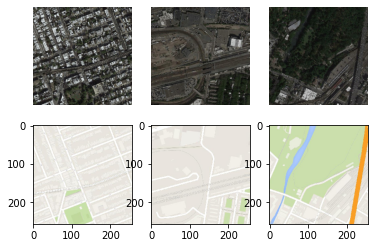

In [ ]:
# load the face dataset
data = load('maps_256.npz')
src_images, tar_images = data['arr_0'], data['arr_1']
print('Loaded: ', src_images.shape, tar_images.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
  pyplot.subplot(2, n_samples, 1 + i)
  pyplot.axis('off')
  pyplot.imshow(src_images[i].astype('uint8'))

# plot target image
for i in range(n_samples):
  pyplot.subplot(2, n_samples, 1 + n_samples + i)
  pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

# define the discriminator model

In [ ]:
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Input, Concatenate, Conv2D, LeakyReLU, \
        BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
def define_discriminator(image_shape):
  # weight initialization
  init = RandomNormal(stddev=0.02)
  # source image input
  in_src_image = Input(shape=image_shape)
  # target image input
  in_target_image = Input(shape=image_shape)
  # concatenate images channel-wise
  merged = Concatenate()([in_src_image, in_target_image])
  # C64
  d = Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(merged)
  d = LeakyReLU(alpha=0.2)(d)
  # C128
  d = Conv2D(filters=128, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  # C256
  d = Conv2D(filters=256, kernel_size=(4, 4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  # C512
  d = Conv2D(filters=512, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  # second last output layer
  d = Conv2D(filters=512, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  # patch output
  d = Conv2D(filters=1, kernel_size=(4, 4), padding='same', kernel_initializer=init)(d)
  patch_out = Activation('sigmoid')(d)
  # define model
  model = Model([in_src_image, in_target_image], patch_out)
  # compile model
  opt = Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
  return model

# define an encoder block

In [ ]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
  # weight initialization
  init = RandomNormal(stddev=0.02)
  # add downsampling layer
  g = Conv2D(filters=n_filters, kernel_size=(4, 4), strides=(2, 2), padding='same',
             kernel_initializer=init)(layer_in)
  # conditionally add batch normalization
  if batchnorm:
    g = BatchNormalization()(g)
  # leaky relu activation
  g = LeakyReLU(alpha=0.2)(g)
  return g

# define a decoder block

In [ ]:
from tensorflow.keras.layers import Conv2DTranspose, Dropout, Concatenate

In [ ]:
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
  # weight initialization
  init = RandomNormal(stddev=0.2)
  # add upsampling layer
  g = Conv2DTranspose(filters=n_filters, kernel_size=(4, 4), strides=(2, 2), 
                      padding='same', kernel_initializer=init)(layer_in)
  # add batch normalization
  g = BatchNormalization()(g, training=True)
  # conditionally add dropout
  if dropout:
    g = Dropout(rate=0.5)(g, training=True)
  # merge with skip connection
  g = Concatenate()([g, skip_in])
  # relu activation
  g = Activation('relu')(g)
  return g

# Define the standalone generator model

In [ ]:
from tensorflow.keras.layers import Input

In [ ]:
def define_generator(image_shape=(256, 256, 3)):
  # weight initialization
  init = RandomNormal(stddev=0.2)
  # image input
  in_image = Input(shape=image_shape)
  # encoder model
  e1 = define_encoder_block(layer_in=in_image, n_filters=64, batchnorm=False)
  e2 = define_encoder_block(layer_in=e1, n_filters=128)
  e3 = define_encoder_block(layer_in=e2, n_filters=256)
  e4 = define_encoder_block(layer_in=e3, n_filters=512)
  e5 = define_encoder_block(layer_in=e4, n_filters=512)
  e6 = define_encoder_block(layer_in=e5, n_filters=512)
  e7 = define_encoder_block(layer_in=e6, n_filters=512)
  # bottleneck, no batch norm and relu
  b = Conv2D(filters=512, kernel_size=(4, 4), strides=(2, 2), padding='same', 
             kernel_initializer=init)(e7)
  b = Activation('relu')(b)
  # decoder model
  d1 = decoder_block(layer_in=b, skip_in=e7, n_filters=512)
  d2 = decoder_block(layer_in=d1, skip_in=e6, n_filters=512)
  d3 = decoder_block(layer_in=d2, skip_in=e5, n_filters=512)
  d4 = decoder_block(layer_in=d3, skip_in=e4, n_filters=512, dropout=False)
  d5 = decoder_block(layer_in=d4, skip_in=e3, n_filters=256, dropout=False)
  d6 = decoder_block(layer_in=d5, skip_in=e2, n_filters=128, dropout=False)
  d7 = decoder_block(layer_in=d6, skip_in=e1, n_filters=64, dropout=False)
  # output
  g = Conv2DTranspose(filters=3, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d7)
  out_image = Activation('tanh')(g)
  # define model
  model = Model(in_image, out_image)
  return model

# define the combined generator and discriminator model, for updating the generator

In [ ]:
def define_gan(g_model, d_model, image_shape):
  # make weights in the discriminator not trainable
  d_model.trainable = False
  # define the source image
  in_src = Input(shape=image_shape)
  # connect the source image to generator input
  gen_out = g_model(in_src)
  # connect the source input and generator output to the discriminator input
  dis_out = d_model([in_src, gen_out])
  # src image as input, generated image and classification output
  model = Model(in_src, [dis_out, gen_out])
  # compile model
  opt = Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1, 100])
  return model

# load and prepare trainig images

In [ ]:
from numpy import load

In [ ]:
def load_real_samples(filename):
  # load the compressed array
  data = load(filename)
  # unpack the arrays
  X1, X2 = data['arr_0'], data['arr_1']
  # scale drom [0, 255] to [-1, 1]
  X1 = (X1 - 127.5) / 127.5
  X2 = (X2 - 127.5) / 127.5
  return [X1, X2]

# select a batch of random samples, returns images and target

In [ ]:
from numpy.random import randint
from numpy import ones, zeros

In [ ]:
def generate_real_samples(dataset, n_samples, patch_shape):
  # unpack dataset
  trainA, trainB = dataset
  # choose random instances
  ix = randint(0, trainA.shape[0], n_samples)
  # retrieve selected images
  X1, X2 = trainA[ix], trainB[ix]
  # generate 'real' class labels (1)
  y = ones((n_samples, patch_shape, patch_shape, 1))
  return [X1, X2], y

# generate a batch of images, returns images and targets

In [ ]:
def generate_fake_samples(g_model, samples, patch_shape):
  # generate fake instance
  X = g_model(samples)
  # create 'fake' class labels (0)
  y = zeros((len(X), patch_shape, patch_shape, 1))
  return X, y

# generate samples and save as a plot and save model

In [ ]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
  # select a sample of input images
  [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
  # generate a batch of fake samples
  X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
  # scale all pixels from [-1,1] to [0,1]
  X_realA = (X_realA + 1) / 2.0
  X_realB = (X_realB + 1) / 2.0
  X_fakeB = (X_fakeB + 1) / 2.0
  # plot real source images
  for i in range(n_samples):
    pyplot.subplot(3, n_samples, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(X_realA[i])
  # plot generated target image
  for i in range(n_samples):
    pyplot.subplot(3, n_samples, 1 + n_samples + i)
    pyplot.axis('off')
    pyplot.imshow(X_fakeB[i])
  # plot real target image
  for i in range(n_samples):
    pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
    pyplot.axis('off')
    pyplot.imshow(X_realB[i])
  # save plot to file
  filename1 = 'plot_%06d.png' % (step+1)
  pyplot.savefig(filename1)
  pyplot.close()
  # save the generator model
  filename2 = 'model_%06d.h5' % (step+1)
  g_model.save(filename2)
  print('>Saved: %s and %s' % (filename1, filename2))

# train pix2pix model

In [ ]:
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
  # determine the output square of the discriminator
  n_patch = d_model.output_shape[1]
  # unpack dataset
  trainA, trainB = dataset
  # calculate the number of batches per training epoch
  bat_per_epo = int(len(trainA) / n_batch)
  # calculate the number of training iterations
  n_steps = bat_per_epo * n_epochs
  # manually enumerate epochs
  for i in range(n_steps):
    # select a batch of real samples
    [X_realA, X_realB], y_real = generate_real_samples(dataset, n_samples=n_batch, patch_shape=n_patch)
    # generate a batch of fake samples
    X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
    # update discriminator for real samples
    d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
    # update discriminator for generated samples
    d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
    # update the generator
    g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
    # summarize performance
    print(">%d, d1[%.3f] d2[%.3f] g[%.3f]" % (i+1, d_loss1, d_loss2, g_loss))
    # summarize model performance
    if (i+1) % (bat_per_epo * 10) == 0:
      summarize_performance(i, g_model, dataset)

# Run the model

In [ ]:
# load image data
dataset = load_real_samples('maps_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
train(d_model, g_model, gan_model, dataset)

Streaming output truncated to the last 5000 lines.
>104602, d1[0.000] d2[0.000] g[3.992]
>104603, d1[0.000] d2[0.000] g[4.115]
>104604, d1[0.000] d2[0.000] g[2.405]
>104605, d1[0.000] d2[0.000] g[4.857]
>104606, d1[0.000] d2[0.000] g[5.420]
>104607, d1[0.000] d2[0.000] g[4.989]
>104608, d1[0.000] d2[0.000] g[4.280]
>104609, d1[0.000] d2[0.000] g[4.865]
>104610, d1[0.000] d2[0.000] g[3.418]
>104611, d1[0.000] d2[0.000] g[4.034]
>104612, d1[0.000] d2[0.000] g[4.697]
>104613, d1[0.000] d2[0.000] g[3.593]
>104614, d1[0.000] d2[0.000] g[3.799]
>104615, d1[0.000] d2[0.000] g[4.408]
>104616, d1[0.000] d2[0.000] g[4.776]
>104617, d1[0.000] d2[0.000] g[7.349]
>104618, d1[0.000] d2[0.000] g[1.862]
>104619, d1[0.000] d2[0.000] g[4.860]
>104620, d1[0.000] d2[0.000] g[5.450]
>104621, d1[0.000] d2[0.000] g[3.827]
>104622, d1[0.000] d2[0.000] g[4.325]
>104623, d1[0.000] d2[0.000] g[4.972]
>104624, d1[0.000] d2[0.000] g[6.103]
>104625, d1[0.000] d2[0.000] g[5.342]
>104626, d1[0.000] d2[0.000] g[4.417]

# load and prepare training images

In [ ]:
def load_real_samples(filename):
  # load the compressed arrays
  data = load(filename)
  # unpack the arrays
  X1, X2 = data['arr_0'], data['arr_1']
  # scale from [0, 255] to [-1, 1]
  X1 = (X1 - 127.5) / 127.5
  X2 = (X2 - 127.5) / 127.5
  return [X1, X2]

In [ ]:
[X1, X2] = load_real_samples('maps_256.npz')
print('Loaded', X1.shape, X2.shape)

Loaded (1096, 256, 256, 3) (1096, 256, 256, 3)


# load model

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('model_109600.h5')

In [ ]:
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

In [ ]:
gen_image = model.predict(src_image)

# plot source, generated and target images

In [ ]:
from numpy import vstack

In [ ]:
def plot_images(src_img, gen_img, tar_img):
  images = vstack((src_img, gen_img, tar_img))
  # scale from [-1, 1] to [0, 1]
  images = (images + 1 ) / 2.0
  titles = ['Source', 'Generated', 'Expected']
  # plot images row by row
  for i in range(len(images)):
    # define subplot
    pyplot.subplot(1, 3, 1 + i)
    # turn off axis
    pyplot.axis('off')
    # plot raw pixel data
    pyplot.imshow(images[i])
    # show title
    pyplot.title(titles[i])
  pyplot.show()

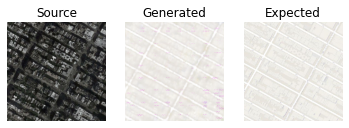

In [ ]:
plot_images(src_image, gen_image, tar_image)